# Test EV control error

After test the EV control error, there is always a gap between the EV actual response power and the estiamted response power.

Now I think the error is inevitable, because the EV SSM has such drawback.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ev_ssm import ev_ssm
from ev_ssm import r_agc_sev
from tqdm import tqdm

In [2]:
# --- Control Error ---
Pil = []
Prl = []
Pcl = []
error = []
t0 = 10.8
for Pi in np.arange(0.5, 8, 0.2):
        sse = ev_ssm(ts=t0, N=10000, step=1, tp=40,
                lr=0.1, lp=40, seed=2022, name="EVA")
        sse.load_A("Aest.csv")

        c0 = sse.ev.c
        sse.run(tf=t0 + 1.5/3600, Pi=Pi,
                is_updateA=False, is_rstate=True,
                is_test=False, disable=False)

        [u, v, us, vs] = sse.uv
        [A, B, C, D] = [sse.A, sse.B, sse.C, sse.D]

        Pil.append(Pi)
        Prl.append(sse.Pr)
        Pcl.append(sse.Prc)
        error.append((sse.Prc - sse.Pr) / sse.Pr)

EVA: ts=10.8[H], 10000 EVs, Total Q=250.12 MWh
Online 1613, Q=40.54 MWh, SoC=0.968
Power(MW): Pt=-0.5954, Pc=-0.5954, Pd=-0.0
Ctrl: 0=1513; 1=100; 
EVA: Load A from Aest.csv.
EVA MCS: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]
EVA: ts=10.8[H], 10000 EVs, Total Q=250.12 MWh
Online 1613, Q=40.54 MWh, SoC=0.968
Power(MW): Pt=-0.5954, Pc=-0.5954, Pd=-0.0
Ctrl: 0=1513; 1=100; 
EVA: Load A from Aest.csv.
EVA MCS: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]
EVA: ts=10.8[H], 10000 EVs, Total Q=250.12 MWh
Online 1613, Q=40.54 MWh, SoC=0.968
Power(MW): Pt=-0.5954, Pc=-0.5954, Pd=-0.0
Ctrl: 0=1513; 1=100; 
EVA: Load A from Aest.csv.
EVA MCS: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]
EVA: ts=10.8[H], 10000 EVs, Total Q=250.12 MWh
Online 1613, Q=40.54 MWh, SoC=0.968
Power(MW): Pt=-0.5954, Pc=-0.5954, Pd=-0.0
Ctrl: 0=1513; 1=100; 
EVA: Load A from Aest.csv.
EVA MCS: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
EVA: ts=10.8[H], 10000 EVs, Total Q=250.12 MWh
Online 1613, Q=40.54 MWh, SoC=0.9

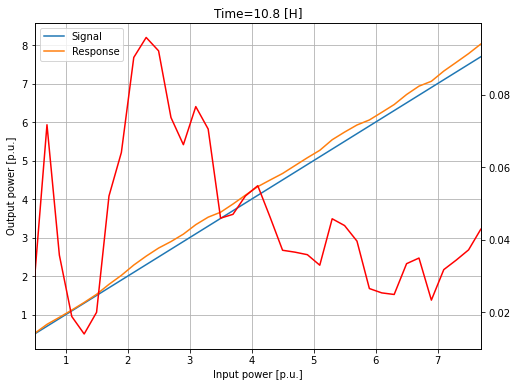

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(Pil, Prl, label="Signal")
ax.plot(Pil, Pcl, label="Response")
ax.set_xlabel("Input power [p.u.]")
ax.set_ylabel("Output power [p.u.]")
ax.set_title(f"Time={sse.tss[0]} [H]")
ax.set_xlim([0.5, 7.7])
ax.grid(True)
ax.legend()
ax2 = ax.twinx()
ax2.plot(Pil, error, label='Error', color='red')

In [4]:
sse.ev[sse.ev.agc != 0].shape

(1363, 21)

In [5]:
sse.ev[sse.ev.u == 1].shape

(1613, 21)

In [6]:
sse.ev[(sse.ev.c0 != sse.ev.c) & (sse.ev.u==1)][['c0', 'c', 'sx']]

,c0,c,sx
4,1,-1,19
8,1,-1,19
15,1,-1,19
32,1,-1,19
39,1,0,19
...,...,...,...
8652,1,0,18
8737,1,0,19
9023,1,-1,19
9397,1,0,16


In [7]:
# --- Single Response ---

Pi = 9

sse = ev_ssm(ts=t0, N=10000, step=1, tp=40,
        lr=0.1, lp=40, seed=2022, name="EVA")
sse.load_A("Aest.csv")

r0 = sse.rtab.values.reshape(-1)
x0 = sse.x0
sse.run(tf=t0 + 1.5/3600, Pi=Pi,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=True)
r = sse.rtab.values.reshape(-1)
x = sse.x0

[u, v, us, vs] = sse.uv
[A, B, C, D] = [sse.A, sse.B, sse.C, sse.D]

print(sse.Pr)
print(sse.Prc)
print(sse.Prc - sse.Pr)

EVA: ts=10.8[H], 10000 EVs, Total Q=250.12 MWh
Online 1613, Q=40.54 MWh, SoC=0.968
Power(MW): Pt=-0.5954, Pc=-0.5954, Pd=-0.0
Ctrl: 0=1513; 1=100; 
EVA: Load A from Aest.csv.


9.0
9.436719865753217
0.43671986575321675


In [8]:
# --- Replay ---
# Replay EV control signal from recorded data
# Replay 1 hour data may need 0.5 hour
# Replay is not accurate

sse_out = pd.read_csv('sse_out.csv')
sse_out_s = sse_out.iloc[1400:1600].reset_index(drop=True)

t0 = sse_out_s['time'].iloc[0]
sse = ev_ssm(ts=t0, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA")
sse.load_A("Aest.csv")

ev_soc = pd.DataFrame(columns=range(sse_out_s.shape[0]))
ev_agc = pd.DataFrame(columns=range(sse_out_s.shape[0]))

for row in tqdm(range(sse_out_s.shape[0]), desc=f'{sse.name} Replay'):
    sse.run(tf=sse_out_s.time.iloc[row], Pi=sse_out_s.Pr.iloc[row],
            is_updateA=False, is_rstate=True,
            is_test=False, disable=True)
    ev_soc[row] = sse.ev.soc
    ev_agc[row] = sse.ev.agc

EVA: ts=10.0[H], 10000 EVs, Total Q=250.12 MWh
Online 1983, Q=49.73 MWh, SoC=0.9834
Power(MW): Pt=-0.3613, Pc=-0.3613, Pd=-0.0
Ctrl: 0=1921; 1=62; 
EVA: Load A from Aest.csv.
EVA Replay: 100%|██████████| 200/200 [01:16<00:00,  2.61it/s]


In [9]:
sse.Prc

0.15452054284417296

In [10]:
sse.Pr

0.1654341694803421

(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [H]', ylabel='Power (MW)'>)

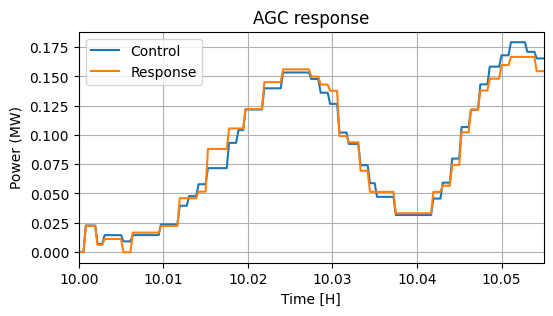

In [11]:
sse.plot_agc()

(<Figure size 600x300 with 2 Axes>,
 <AxesSubplot:title={'center':'EVA'}, xlabel='Time [H]', ylabel='Power (MW)'>)

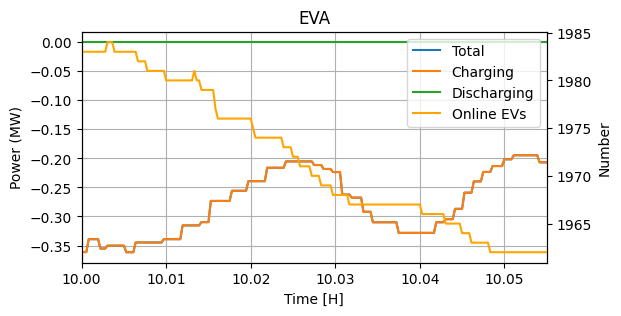

In [18]:
sse.plot()